In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

import jax.numpy as jnp
import numpy as np
import pickle
from jax import jit
import jax.random as random
rng = random.PRNGKey(2022)
import jax.example_libraries.optimizers as optimizers
from jax.flatten_util import ravel_pytree

import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.stats import gamma, lognorm
import pandas as pd
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

from mat_models import MR, mn_sigma_vmap as mn_sigma
from utils_node import init_params, init_params_aniso, NODE_model, NODE_model_aniso, NODE
from utils import train_jp, eval_Cauchy_aniso, eval_Cauchy_aniso_vmap, merge_weights_aniso
from utils_diffusion import *

import GPy

from jaxbo.mcmc_models import ReimannianMFGPclassifierFourier, ReimannianGPclassifierFourier
from jaxbo.input_priors import uniform_prior
from sklearn.metrics import balanced_accuracy_score
from meshutils.Mesh import Mesh
import meshio
from scipy.linalg import eigh

In [45]:
font = {'family' : 'serif',
        'size'   : 35}

matplotlib.rc('font', **font)

In [116]:
def plotmesh(elements, node_X, c_elem, ax, title='mesh'):
    n_elem = len(elements)
    # fig, ax = plt.subplots(figsize=(15,7))

    r = np.abs(np.max(node_X)-np.min(node_X))
    ax.set_xlim([np.min(node_X)-0.1*r, np.max(node_X)+0.1*r])
    ax.set_ylim([np.min(node_X)-0.1*r, np.max(node_X)+0.1*r])
    ax.set_aspect('equal')
    patches=[]
    #viridis = matplotlib.cm.get_cmap('viridis', 50)
    colors = np.zeros((n_elem))
    for i in range(n_elem):
        n1 = elements[i,0]
        n2 = elements[i,1]
        n3 = elements[i,2]
        n4 = elements[i,3]
        polygon = Polygon([node_X[n1],node_X[n2],node_X[n3],node_X[n4]], edgecolor='r', facecolor=None, closed=True)
        patches.append(polygon)
        colors[i] = c_elem[i] #0.25*(aux_X[n1] + aux_X[n2] + aux_X[n3] + aux_X[n4])
    p = PatchCollection(patches, edgecolor='k', facecolor='gray')
    p.set_array(colors)
    ax.add_collection(p)
    ax.set_title(title)
    return ax, p

def plotmesh3(elements, node_X, c_elem, ax, title='mesh'):
    n_elem = len(elements)
    # fig, ax = plt.subplots(figsize=(15,7))

    r = np.abs(np.max(node_X)-np.min(node_X))
    ax.set_xlim([np.min(node_X)-0.1*r, np.max(node_X)+0.1*r])
    ax.set_ylim([np.min(node_X)-0.1*r, np.max(node_X)+0.1*r])
    ax.set_aspect('equal')
    patches=[]
    colors = np.zeros((n_elem))
    for i in range(n_elem):
        n1 = elements[i,0]
        n2 = elements[i,1]
        n3 = elements[i,2]
        polygon = Polygon([node_X[n1],node_X[n2],node_X[n3]], edgecolor='r', facecolor=None, closed=True)
        patches.append(polygon)
    p = PatchCollection(patches, edgecolor='k', facecolor='gray', linewidth=3)
    ax.add_collection(p)
    ax.set_title(title)
    return ax, p

In [3]:
n_neurons = 5
with open('params/mice_node_m_width_'+str(n_neurons)+'.npy', 'rb') as f:
    params_all = pickle.load(f)
with open('params/mice_node_sample_params.npy', 'rb') as f:
    Sample_params = pickle.load(f)
unravel_params = ravel_pytree(Sample_params[0])[1]

In [25]:
# Read the nodes and elements
path = 'fem/square/'
fname = 'square_equi'
file = path + fname + '.inp'
with open(file) as f:
    lines = [line.rstrip('\n') for line in f]

# Get the elements (only needed for plotting the mesh)
i1 = -1
i2 = -1
for i, line in enumerate(lines):
    if line.find('*Element') >= 0:
        # get the element type
        j = line.find('=')
        elemtype = line[j+1:]
        i1 = i+1
        break


for j, line in enumerate(lines[i1:]):
    if line.find('*') >= 0:
        i2 = i1+j
        break
elems = lines[i1:i2]
elems = [line.split() for line in elems]
elems = [[a.rstrip(',') for a in line] for line in elems]
elems = np.array(elems, dtype=int)
elems = elems[:,1:]


# Get the nodes (needed for generating the Gaussian Fields, and for plotting)
i1 = -1
i2 = -1
for i, line in enumerate(lines): # Find the line that starts with '*Node'
    if line.find('*Node') >= 0:
        i1 = i+1
        break
for i, line in enumerate(lines): # Find the line that starts with '*Element' 
    if line.find('*Element') >= 0:
        i2 = i
        break
lines = lines[i1:i2]
lines = [line.split() for line in lines]
lines = [[a.rstrip(',') for a in line] for line in lines]
node_X = np.array(lines, dtype=float)
nodes = np.array(node_X[:,0],dtype=int)
node_X = node_X[:,1:3]
node_X = np.hstack([node_X, np.zeros(len(node_X))[:,None]]) # Add a z coordinate

4.36 4.365


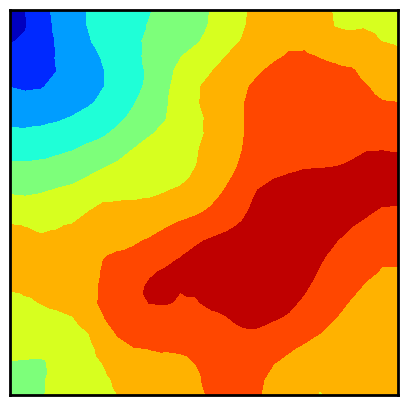

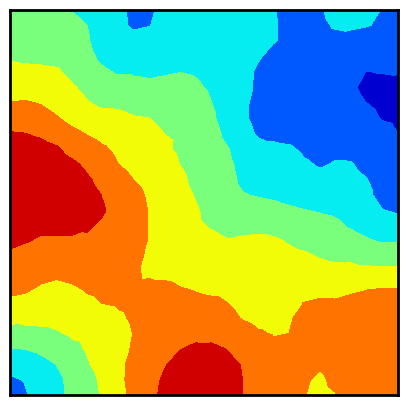

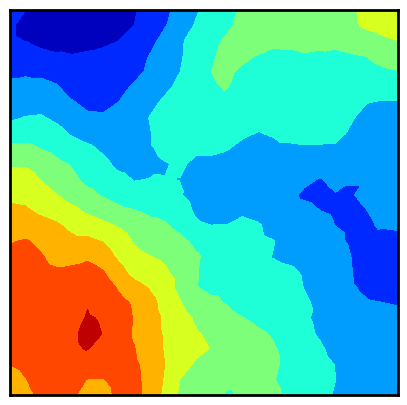

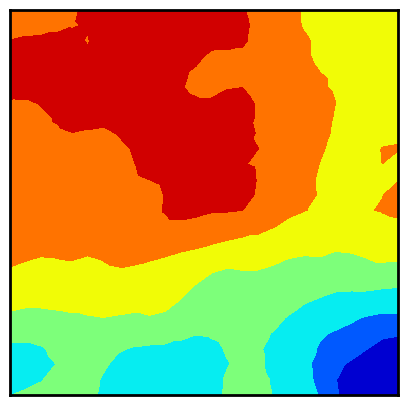

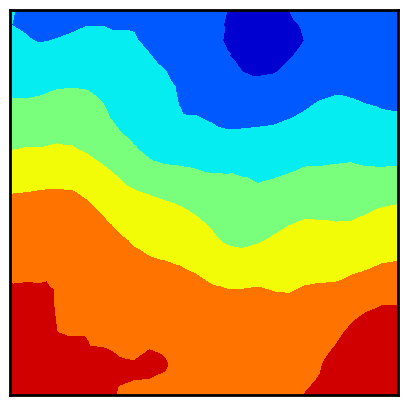

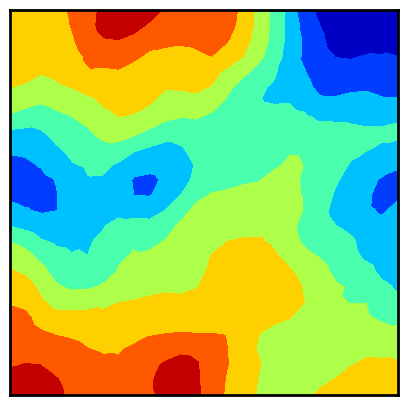

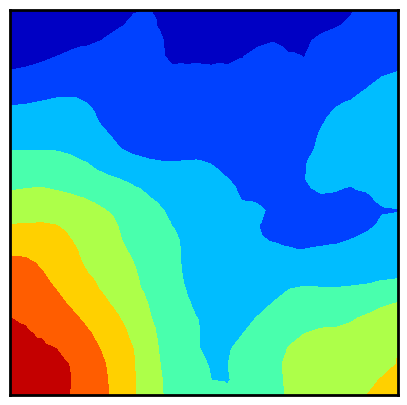

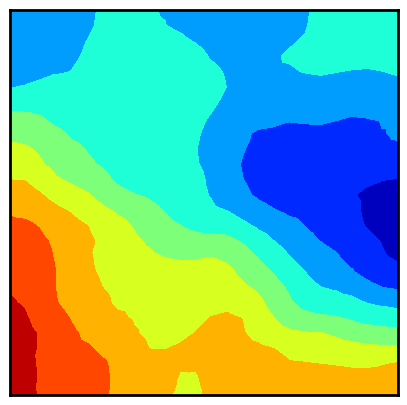

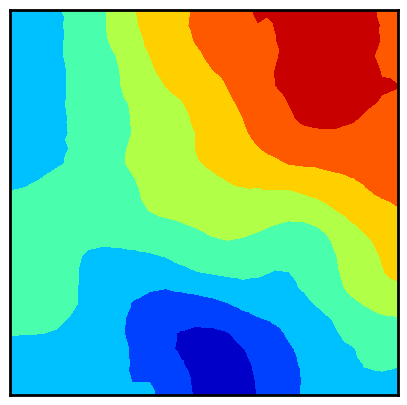

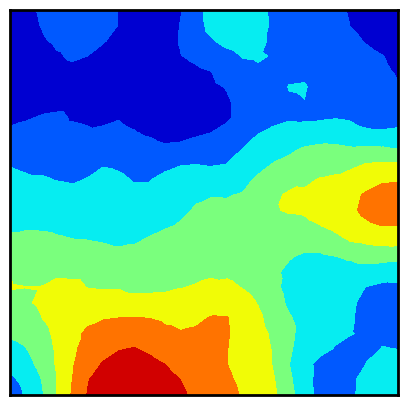

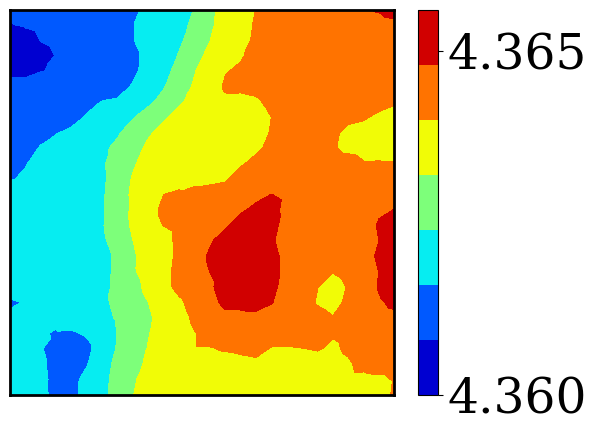

In [54]:
sgmmsr = 0.06
lenscale2 = 0.6
lenscale = np.round(lenscale2*np.max(node_X),1)
init = 1
outfile = path + fname + '_sgmmsr_{}_lenscale_{}_init_{}_sample_params.txt'.format(sgmmsr, lenscale2, int(init))
with open(outfile, 'rb') as f:
    sample_params = pickle.load(f)
sample_params = np.array(sample_params)

for i in range(10):
    fig, ax = plt.subplots(figsize=(5,5))
    # ax.axis('off')
    ax.tricontourf(node_X[:,0], node_X[:,1], elems-1, sample_params[:,i], cmap='jet')
    ax.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
    f = 'tikz/fig_square_fields/square_lenscale_{}_init_{}_param_{}.png'.format(lenscale, int(init), i)
    fig.savefig(f, transparent=True)

stat = []
for sparams in sample_params:
    sparams = unravel_params(sparams)
    params = merge_weights_aniso(params_all, sparams)
    mymodel = NODE_model_aniso(params)
    lmbx = np.linspace(1,1.1) 
    sigx, sigy = eval_Cauchy_aniso_vmap(lmbx,lmbx, mymodel) # Equibi
    stat.append(sigx[-1])

fig, ax = plt.subplots(figsize=(6.2,5))
tcf = ax.tricontourf(node_X[:,0], node_X[:,1], elems-1, np.array(stat)*1000, cmap='jet')
ax.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
cbar = fig.colorbar(tcf) # label='$\sigma_{xx}$ at $\lambda_x=\lambda_y=1.1$ [kPa]'
# cbar.set_ticks([4.348, 4.364])
# cbar.set_ticks([4.354, 4.366])
cbar.set_ticks([4.360, 4.365])
f = 'tikz/fig_square_fields/square_lenscale_{}_init_{}_stress_at_1.1.png'.format(lenscale, int(init), i)
fig.savefig(f, transparent=True)


l = np.round(np.min(stat)*1000,3)
u = np.round(np.max(stat)*1000,3)
print(l, u)

In [55]:
# Read the nodes and elements
path = 'fem/PurdueP/'
fname = 'PP_fine_filleted'
file = path + fname + '.inp'
with open(file) as f:
    lines = [line.rstrip('\n') for line in f]

# Get the elements (only needed for plotting the mesh)
i1 = -1
i2 = -1
for i, line in enumerate(lines):
    if line.find('*Element') >= 0:
        # get the element type
        j = line.find('=')
        elemtype = line[j+1:]
        i1 = i+1
        break


for j, line in enumerate(lines[i1:]):
    if line.find('*') >= 0:
        i2 = i1+j
        break
elems = lines[i1:i2]
elems = [line.split() for line in elems]
elems = [[a.rstrip(',') for a in line] for line in elems]
elems = np.array(elems, dtype=int)
elems = elems[:,1:]


# Get the nodes (needed for generating the Gaussian Fields, and for plotting)
i1 = -1
i2 = -1
for i, line in enumerate(lines): # Find the line that starts with '*Node'
    if line.find('*Node') >= 0:
        i1 = i+1
        break
for i, line in enumerate(lines): # Find the line that starts with '*Element' 
    if line.find('*Element') >= 0:
        i2 = i
        break
lines = lines[i1:i2]
lines = [line.split() for line in lines]
lines = [[a.rstrip(',') for a in line] for line in lines]
node_X = np.array(lines, dtype=float)
nodes = np.array(node_X[:,0],dtype=int)
node_X = node_X[:,1:3]
node_X = np.hstack([node_X, np.zeros(len(node_X))[:,None]]) # Add a z coordinate

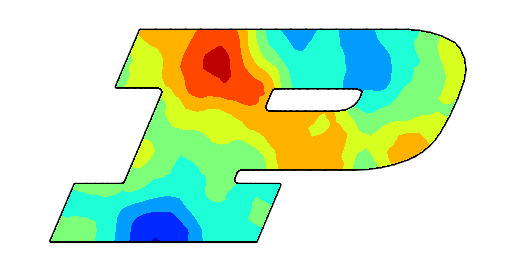

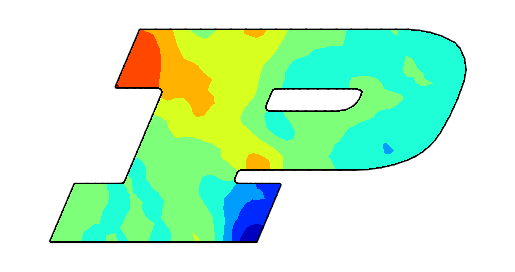

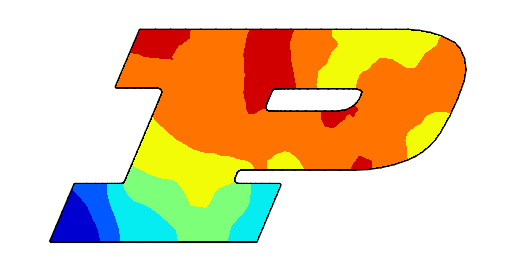

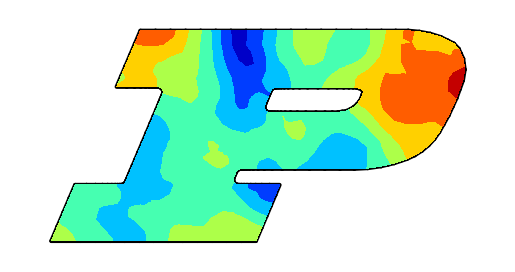

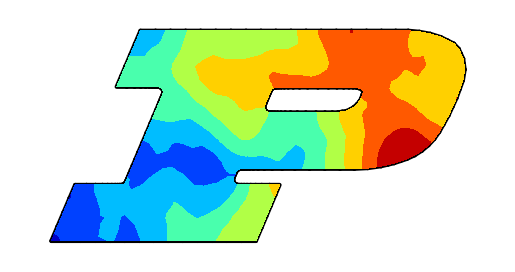

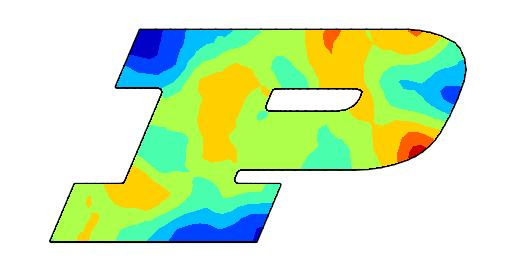

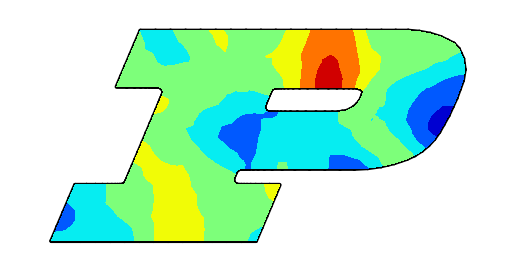

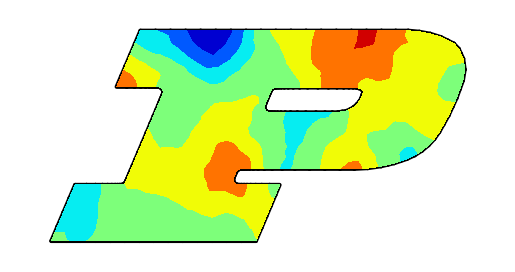

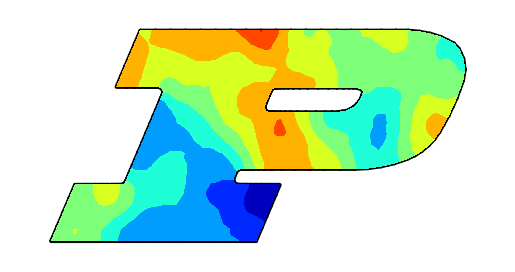

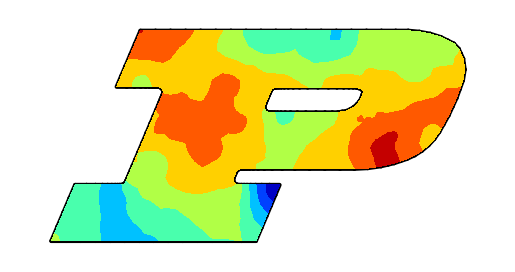

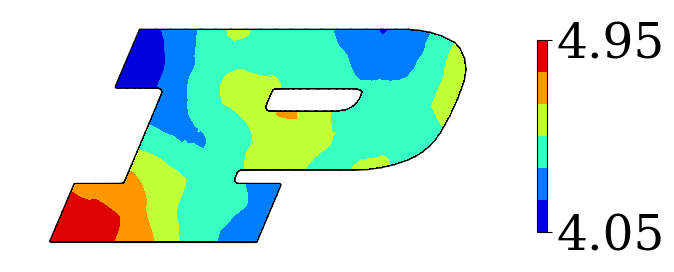

In [124]:
sgmmsr = 0.06
lenscale = 0.2
init = 1
outfile = path + fname + '_sgmmsr_{}_lenscale_{}_init_{}_sample_params.txt'.format(sgmmsr, lenscale, int(init))
with open(outfile, 'rb') as f:
    sample_params = pickle.load(f)
sample_params = np.array(sample_params)

for i in range(10):
    fig, ax = plt.subplots()
    ax.axis('off')
    plotmesh3(elems-1, node_X[:,:2], sample_params[:,i], ax, title="")
    ax.tricontourf(node_X[:,0], node_X[:,1], elems-1, sample_params[:,i], cmap='jet')
    ax.set(ylim=[-0.1,1.1])
    fig.savefig('tikz/fig_PP_fields/PP_lenscale_{}_init_{}_param_{}.png'.format(lenscale, int(init), i), transparent=True)

stat = []
for sparams in sample_params:
    sparams = unravel_params(sparams)
    params = merge_weights_aniso(params_all, sparams)
    mymodel = NODE_model_aniso(params)
    lmbx = np.linspace(1,1.1) 
    sigx, sigy = eval_Cauchy_aniso_vmap(lmbx,lmbx, mymodel) # Equibi
    stat.append(sigx[-1])

fig, ax = plt.subplots(figsize=(8,5))
ax.axis('off')
plotmesh3(elems-1, node_X[:,:2], sample_params[:,i], ax, title="")
tcf = ax.tricontourf(node_X[:,0], node_X[:,1], elems-1, np.array(stat)*1000, cmap='jet')
ax.set(ylim=[-0.1,1.1])
cbar = fig.colorbar(tcf, shrink=0.5)
cbar.set_ticks([4.05, 4.95])
# cbar.set_ticks([4.08, 4.72])
# cbar.set_ticks([4.15, 4.35])
fig.savefig('tikz/fig_PP_fields/PP_lenscale_{}_init_{}_stress_at_1.1.png'.format(lenscale, int(init), i), transparent=True)